# PERSAMAAN PANAS 2 DIMENSI

In [ ]:
import deepxde as dde
import numpy as np

# library untuk membuat animasi:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib import cm

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [ ]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'
dde.config.set_default_float("float64")
dde.optimizers.config.set_LBFGS_options(maxiter=15000)

Set the default float type to float64


# PINN

In [ ]:
# solusi analitik persamaan panas 2d
def heat_eq_exact_solution(x, y, t):
    return np.exp(-(2 * np.pi**2 * a * t)) * np.sin(np.pi * x) * np.sin(np.pi * y)

# fungsi untuk menghitung solusi analitik
def gen_exact_solution():
    # jumlah titik tiap dimensi:
    x_dim, y_dim, t_dim = (100, 100, 100)

    # batas dari x dan t:
    x_min, y_min, t_min = (0, 0, 0.0)
    x_max, y_max, t_max = (L, L, maxtime)

    # titik titik yg akan dicari solusinya:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    y = np.linspace(y_min, y_max, num=y_dim).reshape(y_dim, 1)
    usol = np.zeros((x_dim, y_dim, t_dim)).reshape(x_dim, y_dim, t_dim)

    # peroleh solusi tiap titik:
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(t_dim):
                usol[i][j][k] = heat_eq_exact_solution(x[i], y[j], t[k])

    # Save:
    np.savez("heat_eq_data", x=x, y=y, t=t, usol=usol)

# fungsi untuk membaca data analitik
def gen_testdata():
    # Load data:
    data = np.load("heat_eq_data.npz")
    t, x, y, exact = data["t"], data["x"], data["y"], data["usol"].T
    # ratakan data:
    yy, tt, xx = np.meshgrid(y, t, x)
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    Y = exact.flatten()[:, None]
    return X, Y

In [ ]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # panjang interval
maxtime = .5

In [ ]:
# peroleh solusi analitik
gen_exact_solution()

In [ ]:
def pde(x, u):
    # persamaan diferensial parsial: persamaan panas 2d
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    return (du_t - (a * (du_xx + du_yy)))

In [ ]:
# geometri domain permasalahan
geom = dde.geometry.Rectangle((0,0), (L,L))
timedomain = dde.geometry.TimeDomain(0, maxtime)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(np.pi * x[:, 0:1])*np.sin(np.pi * x[:, 1:2]),
    lambda _, on_initial: on_initial,
                    )

In [ ]:
# definisi PDP dan konfigurasi neural network
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=5000,
    num_boundary=200,
    num_initial=400,
    num_test=5000,
)
net = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
# Bangun dan latih model dengan 2 metode optimasi
model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])
model.train(iterations=10000)
model.compile("L-BFGS", loss_weights=[1, 1, 1])
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.182814 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 6.492183 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.77e-01, 1.72e-02, 1.71e-01]    [2.81e-01, 1.72e-02, 1.71e-01]    []  
1000      [4.14e-03, 4.11e-03, 5.93e-03]    [3.21e-03, 4.11e-03, 5.93e-03]    []  
2000      [1.80e-03, 1.27e-03, 1.27e-03]    [8.94e-04, 1.27e-03, 1.27e-03]    []  
3000      [1.01e-03, 5.69e-04, 3.88e-04]    [4.69e-04, 5.69e-04, 3.88e-04]    []  
4000      [2.06e-03, 3.82e-04, 2.37e-04]    [1.75e-03, 3.82e-04, 2.37e-04]    []  
5000      [3.56e-04, 1.72e-04, 7.17e-05]    [1.96e-04, 1.72e-04, 7.17e-05]    []  
6000      [2.17e-04, 1.18e-04, 4.52e-05]    [1.27e-04, 1.18e-04, 4.52e-05]    []  
7000      [1.44e-04, 9.33e-05, 3.42e-05]    [8.47e-05, 9.33e-05, 3.42e-05]    []  
8000      [1.05e-04, 7.81e-05, 2.81e-05]    [6.09e-05, 7.81e-05, 2.81e-05]    []  
9000      [8.26e-05, 6.76e-05, 2.44e-05]    [4.71e-05, 6.76e-05, 2.44e-05]    []  
10000     [6.82e-05, 6.02e-05, 2.1

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


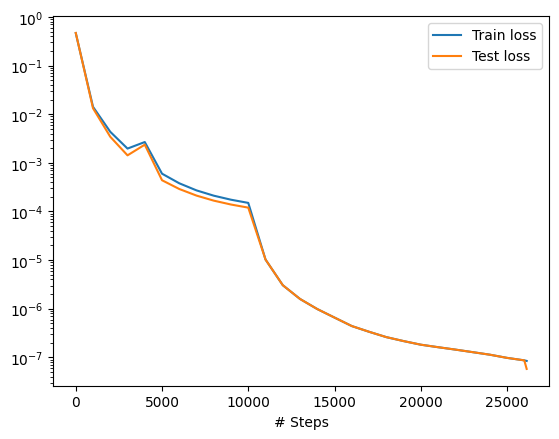

Mean squared error: 5.10102324520334e-09
peak PINN:  [0.99969526]


In [ ]:
# Plot/print hasil
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_PINN = model.predict(X)
print("Mean squared error:", dde.metrics.mean_squared_error(y_true, y_PINN))
print("peak PINN: ", max(y_PINN))
np.savetxt("test.dat", np.hstack((X, y_true, y_PINN)))

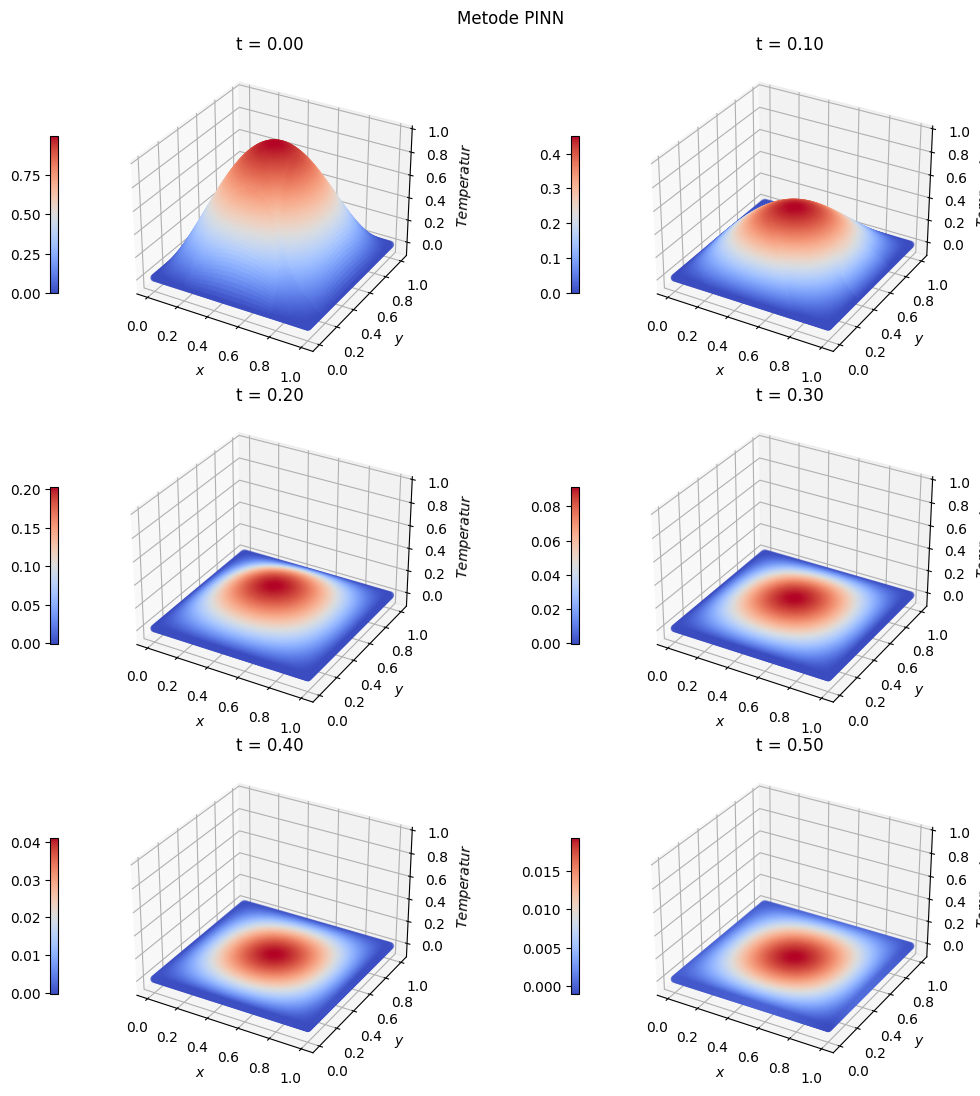

In [ ]:
# Plot hasil yang diperoleh
fig = plt.figure(figsize=(11,11))
plt.suptitle("Metode PINN")

ax = fig.add_subplot(3, 2, 1, projection='3d')
surf = ax.scatter(X[0:10000, 0], X[0:10000, 1], y_PINN[0:10000], c=y_PINN[0:10000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[0, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 2, projection='3d')
surf = ax.scatter(X[200000:210000, 0], X[200000:210000, 1], y_PINN[200000:210000], c=y_PINN[200000:210000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[200000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 3, projection='3d')
surf = ax.scatter(X[400000:410000, 0], X[400000:410000, 1], y_PINN[400000:410000], c=y_PINN[400000:410000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[400000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 4, projection='3d')
surf = ax.scatter(X[600000:610000, 0], X[600000:610000, 1], y_PINN[600000:610000], c=y_PINN[600000:610000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[600000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 5, projection='3d')
surf = ax.scatter(X[800000:810000, 0], X[800000:810000, 1], y_PINN[800000:810000], c=y_PINN[800000:810000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[800000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 6, projection='3d')
surf = ax.scatter(X[990000:1000000, 0], X[990000:1000000, 1], y_PINN[990000:1000000], c=y_PINN[990000:1000000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[990000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

plt.tight_layout()
plt.savefig("PINN2d.png", dpi=300)

# Analytic

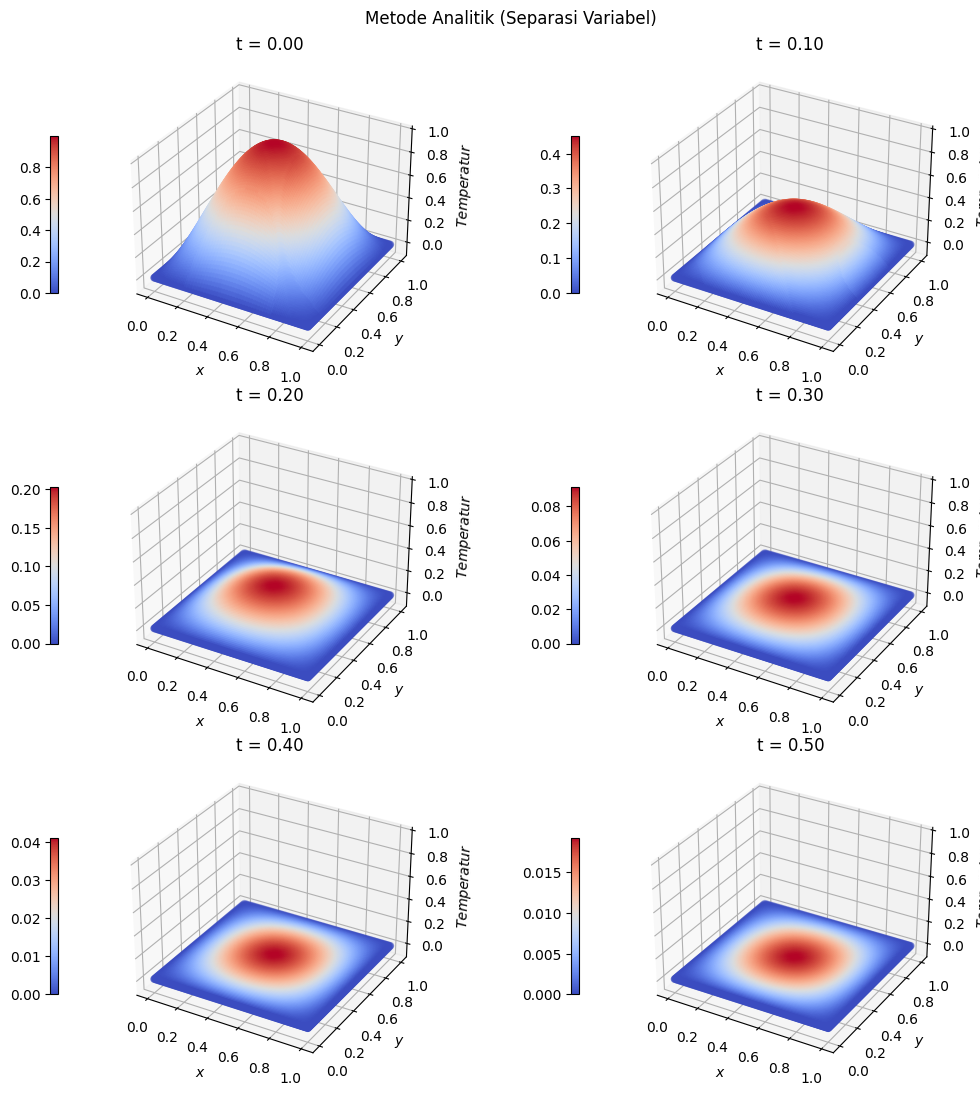

In [ ]:
# plot hasil metode analitik
fig = plt.figure(figsize=(11,11))
plt.suptitle("Metode Analitik (Separasi Variabel)")

ax = fig.add_subplot(3, 2, 1, projection='3d')
surf = ax.scatter(X[0:10000, 0], X[0:10000, 1], y_true[0:10000], c=y_true[0:10000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[0, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 2, projection='3d')
surf = ax.scatter(X[200000:210000, 0], X[200000:210000, 1], y_true[200000:210000], c=y_true[200000:210000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[200000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 3, projection='3d')
surf = ax.scatter(X[400000:410000, 0], X[400000:410000, 1], y_true[400000:410000], c=y_true[400000:410000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[400000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 4, projection='3d')
surf = ax.scatter(X[600000:610000, 0], X[600000:610000, 1], y_true[600000:610000], c=y_true[600000:610000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[600000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 5, projection='3d')
surf = ax.scatter(X[800000:810000, 0], X[800000:810000, 1], y_true[800000:810000], c=y_true[800000:810000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[800000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 6, projection='3d')
surf = ax.scatter(X[990000:1000000, 0], X[990000:1000000, 1], y_true[990000:1000000], c=y_true[990000:1000000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[990000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

plt.tight_layout()
plt.savefig("analytic2d.png", dpi=300)

# Numeric FTCS

In [ ]:
# library untuk menghitung waktu running FTCS
import time
start = time.time()
dx = 0.02
dy = dx
dt = dx**2 / (4*a)

In [ ]:
# inisialisasi domain
xs = np.arange(0, L, dx)
ys = np.arange(0, L, dy)
ts = np.arange(0, maxtime, dt)
u = np.empty((len(xs), len(ys)))
for i in range(len(xs)):
    for j in range(len(ys)):
        u[i, j] = np.sin(np.pi*xs[i]) * np.sin(np.pi*ys[j]) #initial condition

In [ ]:
u[0, :] = 0
u[-1, :] = 0
u[:, 0] = 0
u[:, -1] = 0   #boundary condition

XS, YS = np.meshgrid(xs, ys)
y_num = np.empty(4)

for n in ts: #iterasi melalui waktu
    un = u.copy()
    u[1:-1, 1:-1] = (un[1:-1,1:-1] + a * dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    a * dt / dy**2 * (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    temp = np.hstack((XS.reshape(-1,1), YS.reshape(-1,1), np.full((len(xs) * len(ys)), n).reshape(-1,1), u.reshape(-1,1)))
    y_num = np.vstack((y_num, temp))

y_num = np.delete(y_num, 0, 0)

end = time.time()

print('total waktu kalkulasi FTCS', end-start)

total waktu kalkulasi FTCS 56.23019576072693


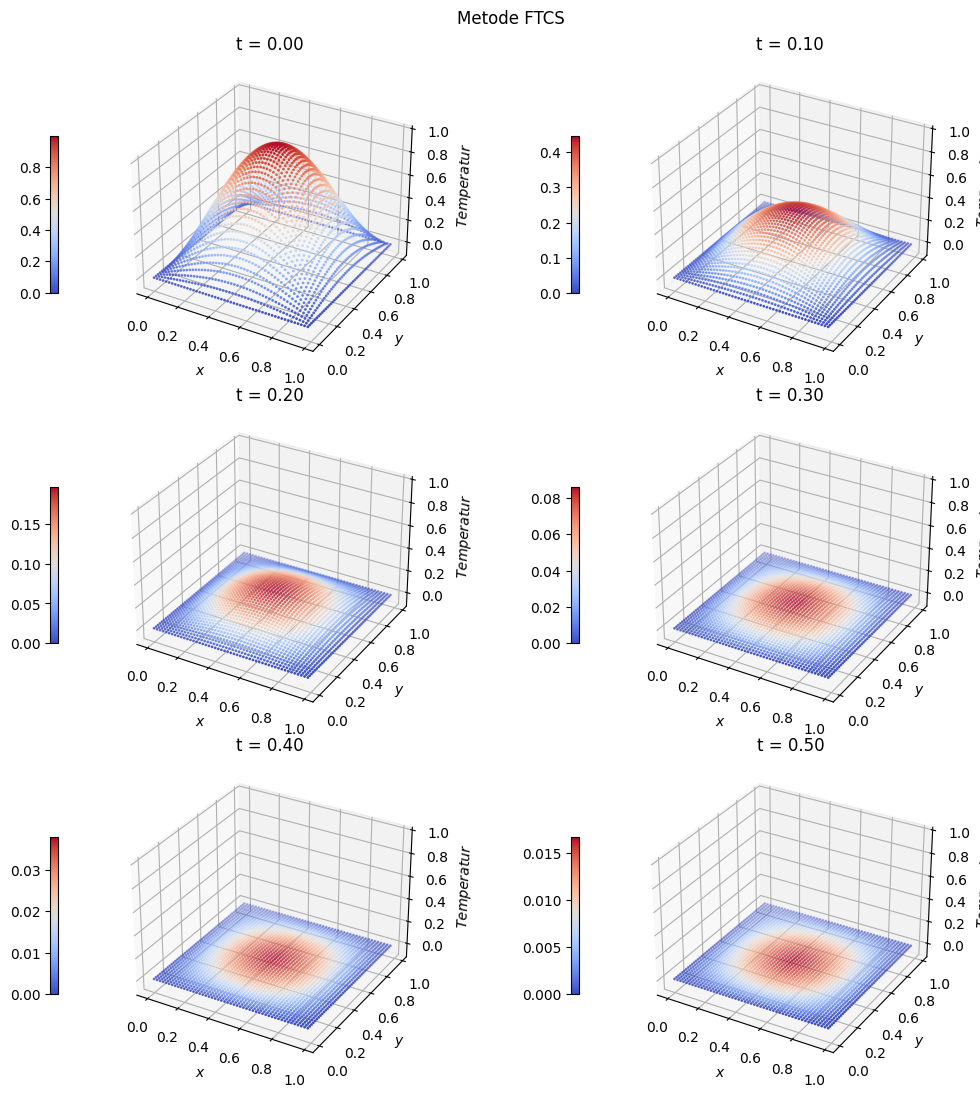

In [ ]:
# plot metode FTCS
fig = plt.figure(figsize=(11,11))
plt.suptitle("Metode FTCS")


markersize = [1 for i in range(2500)]
ax = fig.add_subplot(3, 2, 1, projection='3d')
surf = ax.scatter(y_num[0:2500, 0], y_num[0:2500, 1], y_num[0:2500, 3], s=markersize, c=y_num[0:2500, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[0, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 2, projection='3d')
surf = ax.scatter(y_num[1000000:1002500, 0], y_num[1000000:1002500, 1], y_num[1000000:1002500, 3], s=markersize, c=y_num[1000000:1002500, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[1000000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 3, projection='3d')
surf = ax.scatter(y_num[2000000:2002500, 0], y_num[2000000:2002500, 1], y_num[2000000:2002500, 3], s=markersize, c=y_num[2000000:2002500, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[2000000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 4, projection='3d')
surf = ax.scatter(y_num[3000000:3002500, 0], y_num[3000000:3002500, 1], y_num[3000000:3002500, 3], s=markersize, c=y_num[3000000:3002500, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[3000000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 5, projection='3d')
surf = ax.scatter(y_num[4000000:4002500, 0], y_num[4000000:4002500, 1], y_num[4000000:4002500, 3], s=markersize, c=y_num[4000000:4002500, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[4000000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 6, projection='3d')
surf = ax.scatter(y_num[4997500:5000000, 0], y_num[4997500:5000000, 1], y_num[4997500:5000000, 3], s=markersize, c=y_num[4997500:5000000, 3], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(y_num[4997500, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

plt.tight_layout()
plt.savefig("FTCS2d.png", dpi=300)

In [ ]:
print('mean squared error FTCS: ', dde.metrics.mean_squared_error((heat_eq_exact_solution(y_num[:, 0], y_num[:, 1], y_num[:, 2])), y_num[:, 3]))
print('peak FTCS: ', max(y_num[:, 3]))

mean squared error FTCS:  7.889401864023953e-05
peak FTCS:  0.9980267284282718


# Animation

In [ ]:
# Animasi hasil
result = np.hstack((X, y_true, y_PINN))
time = np.unique(result[:, 2])
time2 = np.unique(y_num[:, 2])

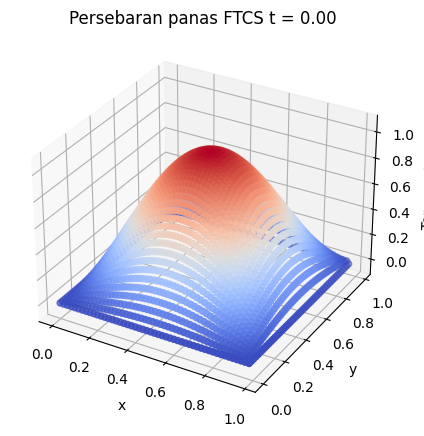

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame):
    ax.clear()
    ax.set_title(" ")
    ax.set_zlim([-.1, 1.1])
    ax.set_zlabel("Temperatur")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.grid()
    # untuk animasi PINN uncomment 4 line berikut
#     a = np.where(result[:, 2] == time[frame])[0][0]
#     b = np.where(result[:, 2] == time[frame])[0][-1]
#     surface = ax.scatter(result[a:b, 0], result[a:b, 1], result[a:b, 4], c=result[a:b, 4], cmap=cm.coolwarm)
#     ax.set_title("Persebaran panas PINN t = {:.2f}".format(result[a, 4]))

    # untuk animasi analitik uncomment 4 line berikut
#     a = np.where(result[:, 2] == time[frame])[0][0]
#     b = np.where(result[:, 2] == time[frame])[0][-1]
#     surface = ax.scatter(result[a:b, 0], result[a:b, 1], result[a:b, 3], c=result[a:b, 3], cmap=cm.coolwarm)
#     ax.set_title("Persebaran panas analitik t = {:.2f}".format(result[a, 3]))

    # untuk animasi FTCS uncomment 4 line berikut
    a = np.where(y_num[:, 2] == time2[frame])[0][0]
    b = np.where(y_num[:, 2] == time2[frame])[0][-1]
    surface = ax.scatter(y_num[a:b, 0], y_num[a:b, 1], y_num[a:b, 3], c=y_num[a:b, 3], cmap=cm.coolwarm)
    ax.set_title("Persebaran panas FTCS t = {:.2f}".format(y_num[a, 2]))

ani = FuncAnimation(fig, update, frames=int(len(time2)))

In [ ]:
# Save animasi sebagai video
# ani.save("heat eq 2d FTCS.mp4", bitrate=6000, dpi=200, fps=200)

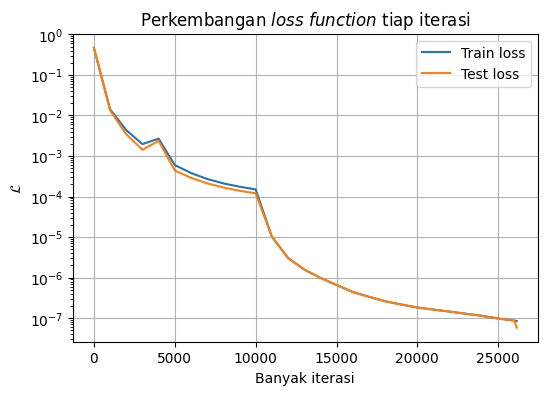

In [ ]:
# simpan plot loss history
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

plt.figure(figsize=(6,4))
plt.grid()
plt.title("Perkembangan $loss$ $function$ tiap iterasi")
plt.semilogy(losshistory.steps, loss_train, label="Train loss")
plt.semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("Banyak iterasi")
plt.ylabel("$\mathcal{L}$")
plt.legend()
plt.savefig('loss.png', dpi=300)